In [1]:
import numpy as np

In [2]:
import pandas as pd

filename = "../data/sample_data.csv"

In [3]:
def compute_factor(all_data, hd1, ai, fhd, complexity, group):
    data = all_data[all_data["Type_AI"] == group]
    condition_subset = data[(data["HD1"] == hd1) & (data["AI"] == ai) & (data["Complexity"] == complexity)]
    weight_subset = data[data["HD1"] == hd1]
    
    condition = condition_subset[condition_subset["FHD"] == fhd]
    weight = len(weight_subset[weight_subset["Complexity"] == complexity])/len(weight_subset)
    
    ratio = 0 if len(condition_subset) == 0 else len(condition)/len(condition_subset)
    
    return ratio, len(condition), len(condition_subset), weight

In [4]:
def compute_causal_dominance(data, cut=False):

    logodds_ab = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                                   len(data["Type_AI"].unique())
                                                 )),
                                       index = data["Study"].unique(),
                                       columns = data["Type_AI"].unique())

    stds_ab = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                                   len(data["Type_AI"].unique())
                                                 )),
                                       index = data["Study"].unique(),
                                       columns = data["Type_AI"].unique())
    
    logodds_av = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                                   len(data["Type_AI"].unique())
                                                 )),
                                       index = data["Study"].unique(),
                                       columns = data["Type_AI"].unique())

    stds_av = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                                   len(data["Type_AI"].unique())
                                                 )),
                                       index = data["Study"].unique(),
                                       columns = data["Type_AI"].unique())
    
    for s in data["Study"].unique():
        #print(s)
        study = data[data["Study"] == s]

        for v in study["Type_AI"].unique():
            #print(v)

            res_ab = np.array([0,0], dtype=np.float64)
            counts_ab = np.array([0,0,0,0], dtype=np.float64)
            
            res_av = np.array([0,0], dtype=np.float64)
            counts_av = np.array([0,0,0,0], dtype=np.float64)

            for c in data["Complexity"].unique():
                val, num, denom, weight = compute_factor(study, 1, 0, 0, c, group=v)
                res_ab[0] += val*weight
                counts_ab[0] += num
                counts_ab[1] += denom

                val, num, denom, weight = compute_factor(study, 1, 0, 1, c, group=v)
                res_ab[1] += val*weight
                counts_ab[2] += num
                counts_ab[3] += denom
                
                val, num, denom, weight = compute_factor(study, 0, 1, 0, c, group=v)
                res_av[0] += val*weight
                counts_av[0] += num
                counts_av[1] += denom

                val, num, denom, weight = compute_factor(study, 0, 1, 1, c, group=v)
                res_av[1] += val*weight
                counts_av[2] += num
                counts_av[3] += denom
        
            logodds_ab.loc[s,v] = np.log(res_ab[0]/(1-res_ab[0])*(1-res_ab[1])/res_ab[1])
            stds_ab.loc[s,v] = np.sqrt(np.sum(1/counts_ab))
            if stds_ab.loc[s,v] == np.inf:
                stds_ab.loc[s,v] = 0
                
            #print("Automation Bias (Causal) [%.2f, %.2f]" % (np.exp(logodds_ab.loc[s,v] - 1.96*stds_ab.loc[s,v]), np.exp(logodds_ab.loc[s,v] + 1.96*stds_ab.loc[s,v])))
            
            logodds_av.loc[s,v] = np.log(res_av[0]/(1- res_av[0])*(1-res_av[1])/res_av[1])
            stds_av.loc[s,v] = np.sqrt(np.sum(1/counts_av))
            if stds_av.loc[s,v] == np.inf:
                stds_av.loc[s,v] = 0
            
            #print("Detrimental Algorithmic Aversion (Causal) [%.2f, %.2f]" % (np.exp(logodds_av.loc[s,v] - 1.96*stds_av.loc[s,v]), np.exp(logodds_av.loc[s,v] + 1.96*stds_av.loc[s,v])))
            #print()
            
    dominance_diagram(logodds_ab, stds_ab, "Automation Bias (Causal)", inverted=True, cut=cut)
    dominance_diagram(logodds_av, stds_av, "Detrimental Algorithmic Aversion (Causal)", inverted=True, cut=cut)
    
    return logodds_ab, logodds_av, stds_ab, stds_av

In [5]:
import itertools
def compute_reliance(data):
    colnames =  "Count (" + data["Type_AI"].unique() + ")"
    patterns = pd.DataFrame(np.zeros((8, 3 + len(colnames)), dtype=int), columns=["HD1","AI","FHD"] + list(colnames))
    lst = list(itertools.product([0, 1], repeat=3))
    for i in range(8):
        for j in range(3):
            patterns.iloc[i,j] = lst[i][j]
        for v in data["Type_AI"].unique():
            patterns.loc[i, "Count (" + v + ")"] = data[((data["HD1"] == lst[i][0]) & 
                                                         (data["AI"] == lst[i][1])  &
                                                         (data["FHD"] == lst[i][2]) &
                                                         (data["Type_AI"] == v))].shape[0]
    #print(patterns.to_string(index=False))
    return patterns

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def dominance_diagram(logodds, stds, title, inverted=False, cut=False):
    plt.figure(figsize=(10,10))
    
    palette = sns.color_palette('colorblind', n_colors=len(logodds.columns))
    
    if inverted:
        plt.axvspan(0.0, 1.0, alpha=0.2, color='blue')
        plt.axvspan(1.0, 1000.0, alpha=0.2, color='red')
    else:
        plt.axvspan(0.0, 1.0, alpha=0.2, color='red')
        plt.axvspan(1.0, 1000.0, alpha=0.2, color='blue')
    
    idx = 1
    for s in logodds.index:
        level = idx - 0.05*len(logodds.columns)/2
        step = 0.05
        
        idj = 0
        
        for v in logodds.columns:
            
            val = np.exp(logodds.loc[s,v])
            lower = np.exp(logodds.loc[s,v]) - np.exp(logodds.loc[s,v] - 1.96*stds.loc[s,v])
            upper = np.exp(logodds.loc[s,v] + 1.96*stds.loc[s,v]) - np.exp(logodds.loc[s,v])
            
            if cut:
                if val > 10:
                    val = 10
                elif val < 0.1:
                    val = 0.1
                    
            #print(val)
            #print(lower)
            #print(upper)
            #print()
                          
            plt.errorbar(val, level,
                         xerr=[[lower],
                               [upper]],
                         fmt="o",
                         color=palette[idj],
                         ecolor='k', zorder=2*idj)
            plt.scatter(val, level,
                         label=v,
                         color=palette[idj],
                         edgecolors='k', zorder=2*idj+1)


            #plt.legend([line1, line2], ["No XAI", "XAI"])

            plt.ylim(0,5)

            plt.xscale("log")
            
            if cut:
                plt.xlim(0.1,10)
                plt.xticks([0.1, 0.2, 0.5, 1, 2, 5, 10], ["< 0.1", 0.2, 0.5, 1, 2, 5, "> 10"])
            else:
                plt.xlim(0.001,1000)
                plt.xticks([0.001,0.01,0.1, 1, 10, 100, 1000], [0.001,0.01,0.1, 1, 10, 100, 1000])
            
            level += step
            if level == 1.0 and len(logodds.columns)%2 == 0:
                level += 0.05
            idj += 1
                
        idx += 1

    plt.ylim(0, len(logodds.index)+1)
    plt.yticks(range(len(logodds.index) + 1), [""] + list(logodds.index) )
    plt.axvline(1, ls='--', c='k', lw=0.75)
    plt.xlabel(title)
    
    handles = []
    i = 0
    for v in logodds.columns:
        handles.append(Line2D([0], [0], marker='o', color=palette[i], label=v,
                              markeredgecolor='k'))
        i += 1
    
    plt.legend(handles, logodds.columns)
    plt.savefig(title + ".png", dpi=500, bbox_inches="tight")

In [7]:
def compute_dominance(data, cut=False):
    
    logodds_general = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    stds_general = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    logodds_ab = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    stds_ab = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    logodds_av = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    stds_av = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())
    
    reliance = {}

    for s in data["Study"].unique():
        study = data[data["Study"] == s]
        
        reliance[s] = compute_reliance(study)
        
        for v in study["Type_AI"].unique():
            #print(v)
            data_temp = study[study["Type_AI"] == v]

            aier = data_temp[((data_temp["HD1"] == 0) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)) |
                      ((data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 0)) |
                      ((data_temp["HD1"] == 1) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)) |
                      ((data_temp["HD1"] == 1) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 0))].shape[0]/data_temp.shape[0]

            cer  = data_temp[((data_temp["HD1"] == 0) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)) |
                       ((data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 0)) |
                       ((data_temp["HD1"] == 0) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 1)) |
                       ((data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 1))].shape[0]/data_temp.shape[0]

            aigr = data_temp[((data_temp["HD1"] == 0) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)) |
                      ((data_temp["HD1"] == 1) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)) |
                      ((data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 1)) |
                      ((data_temp["HD1"] == 1) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 1))].shape[0]/data_temp.shape[0]

            cgr = data_temp[((data_temp["HD1"] == 0) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)) |
                      ((data_temp["HD1"] == 0) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 1)) |
                      ((data_temp["HD1"] == 1) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 0)) |
                      ((data_temp["HD1"] == 1) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 1))].shape[0]/data_temp.shape[0]

            #print("ARR = %.2f" % (cer - aier) )
            #print("NND = %.2f" % (1/(cer - aier)) )
            #print("RR = %.2f" %  (aier/cer) )
            #print("RRR = %.2f" %  (1- (aier/cer)) )


            logodds_general.loc[s,v] = np.log(cer/(1-cer)*(1-aier)/aier)

            stds_general.loc[s,v] =  1/(aier*data_temp.shape[0]+ 0.0000001)
            stds_general.loc[s,v] += 1/(cer*data_temp.shape[0]+ 0.0000001) 
            stds_general.loc[s,v] += 1/((1 - aier)*data_temp.shape[0]+ 0.0000001)
            stds_general.loc[s,v] += 1/((1 - cer)*data_temp.shape[0]+ 0.0000001)
            #print("OR = %.2f" %  np.exp(logodds_general.loc[s,v]))
            #print("Technology Impact [%.2f, %.2f]" % (np.exp(logodds_general.loc[s,v] - 1.96*stds_general.loc[s,v]),
            #                                                      np.exp(logodds_general.loc[s,v] + 1.96*stds_general.loc[s,v])))

            automation_bias = data_temp[(data_temp["HD1"] == 1) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)].shape[0]/data_temp.shape[0]
            algorithmic_aversion = data_temp[(data_temp["HD1"] == 1) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 1)].shape[0]/data_temp.shape[0]
            algorithmic_appreciation = data_temp[(data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 1)].shape[0]/data_temp.shape[0]
            conservatism_bias = data_temp[(data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 0)].shape[0]/data_temp.shape[0]

            logodds_ab.loc[s,v] = np.log(automation_bias/(1-automation_bias)*(1-algorithmic_aversion)/algorithmic_aversion)
            stds_ab.loc[s,v] =  1/(automation_bias*data_temp.shape[0] + 0.0000001) 
            stds_ab.loc[s,v] =+ 1/(algorithmic_aversion*data_temp.shape[0]+ 0.0000001) 
            stds_ab.loc[s,v] =+ 1/(data_temp.shape[0] - automation_bias*data_temp.shape[0]+ 0.0000001) 
            stds_ab.loc[s,v] =+ 1/(data_temp.shape[0] - algorithmic_aversion*data_temp.shape[0]+ 0.0000001)
            #print("Automation Bias [%.2f, %.2f]" % (np.exp(logodds_ab.loc[s,v]- 1.96*stds_ab.loc[s,v]),
            #                                                 np.exp(logodds_ab.loc[s,v] + 1.96*stds_ab.loc[s,v])))

            logodds_av.loc[s,v] = np.log(conservatism_bias/(1 - conservatism_bias)*(1-algorithmic_appreciation)/algorithmic_appreciation)
            stds_av.loc[s,v] =  1/(conservatism_bias*data_temp.shape[0]+ 0.0000001) 
            stds_av.loc[s,v] =+ 1/(algorithmic_appreciation*data_temp.shape[0]+ 0.0000001) 
            stds_av.loc[s,v] =+ 1/(data_temp.shape[0] - conservatism_bias*data_temp.shape[0]+ 0.0000001) 
            stds_av.loc[s,v] =+ 1/(data_temp.shape[0] - algorithmic_appreciation*data_temp.shape[0]+ 0.0000001)
            #print("Detrimental Algorithmic Aversion [%.2f, %.2f]" % (np.exp(logodds_av.loc[s,v] - 1.96*stds_av.loc[s,v]),
            #                                                                  np.exp(logodds_av.loc[s,v] + 1.96*stds_av.loc[s,v])))
            #print()
            
    dominance_diagram(logodds_general, stds_general, "Tecnology Impact", cut=cut)
    dominance_diagram(logodds_ab, stds_ab, "Automation Bias", inverted=True, cut=cut)
    dominance_diagram(logodds_av, stds_av, "Detrimental Algorithmic Aversion", inverted=True, cut=cut)
    return reliance, cer, aier, logodds_general, logodds_ab, logodds_av, stds_general, stds_ab, stds_av



In [8]:
def compute_chi_diagrams(filename, cut=False):
    data = pd.read_csv(filename)
    
    if ("HD1" not in data.columns):
        return "Mandatory field HD1 is missing!"
    if ("AI" not in data.columns):
        return "Mandatory field AI is missing!"
    if ("FHD" not in data.columns):
        return "Mandatory field FHD is missing!"
    
    if "Type_AI" not in data.columns:
        data["Type_AI"] = ""
        
    if "Study" not in data.columns:
        data["Study"] = ""
        
    if "Complexity" not in data.columns:
        data["Complexity"] = ""
        
    reliance, cer, aier, logodds_general, logodds_ab, logodds_av, stds_general, stds_ab, stds_av = compute_dominance(data, cut=cut)
    logodds_ab_causal, logodds_av_causal, stds_ab_causal, stds_av_causal = compute_causal_dominance(data, cut=cut)
    
    #print("ARR = %.2f" % (cer - aier) )
            #print("NND = %.2f" % (1/(cer - aier)) )
            #print("RR = %.2f" %  (aier/cer) )
            #print("RRR = %.2f" %  (1- (aier/cer)) )
            
    #np.exp(logodds_av.loc[s,v] - 1.96*stds_av.loc[s,v]), np.exp(logodds_av.loc[s,v] + 1.96*stds_av.loc[s,v])))
    lower_gen = np.exp(logodds_general - 1.96*stds_general)
    upper_gen = np.exp(logodds_general + 1.96*stds_general)
    lower_ab = np.exp(logodds_ab - 1.96*stds_ab)
    upper_ab = np.exp(logodds_ab + 1.96*stds_ab)
    lower_av = np.exp(logodds_av - 1.96*stds_av)
    upper_av = np.exp(logodds_av + 1.96*stds_av)
    lower_ab_caus = np.exp(logodds_ab_causal - 1.96*stds_ab_causal)
    upper_ab_caus = np.exp(logodds_ab_causal + 1.96*stds_ab_causal)
    lower_av_caus = np.exp(logodds_av_causal - 1.96*stds_av_causal)
    upper_av_caus = np.exp(logodds_av_causal + 1.96*stds_av_causal)
    
    return reliance, cer - aier, 1/(cer - aier), aier/cer, 1 - aier/cer, lower_gen, upper_gen, lower_ab, upper_ab, lower_av, upper_av, lower_ab_caus, upper_ab_caus, lower_av_caus, upper_av_caus

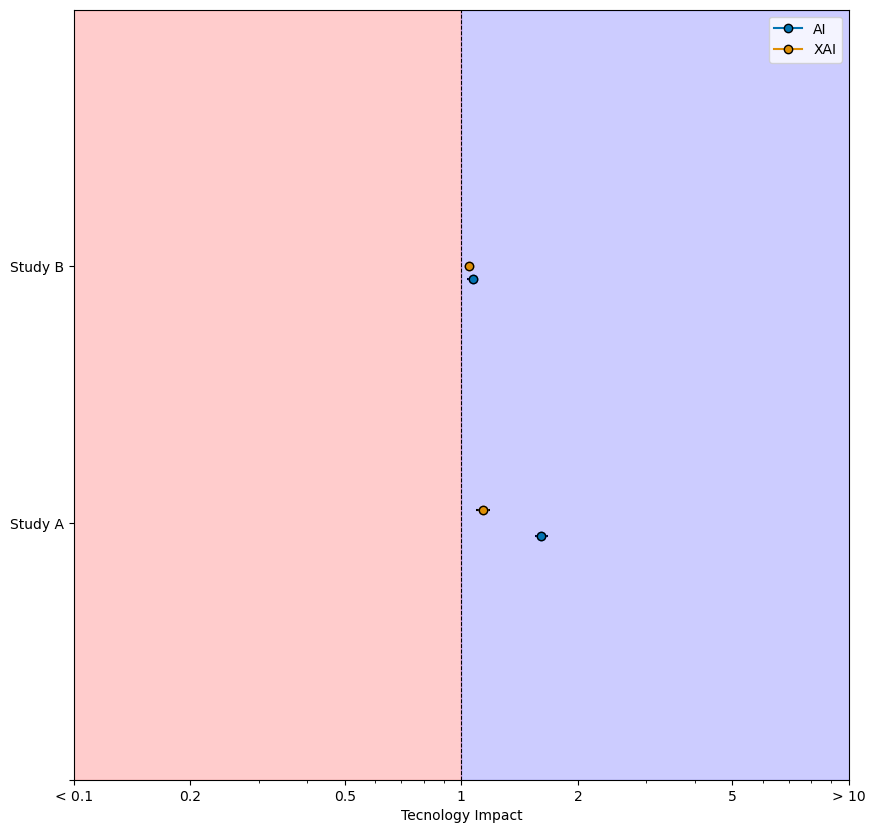

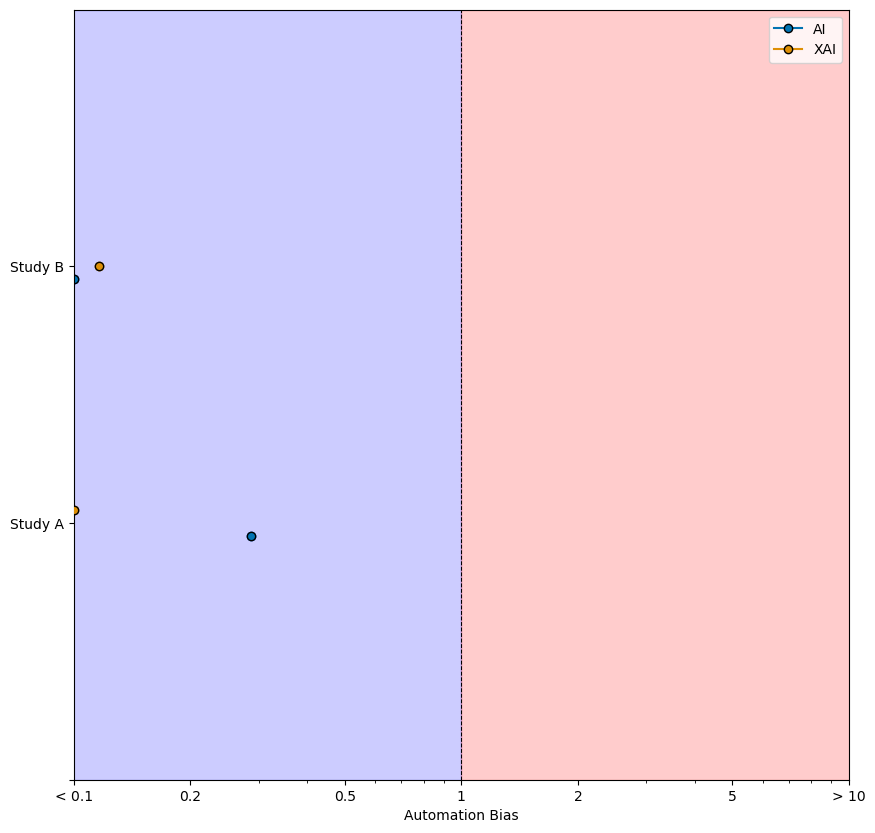

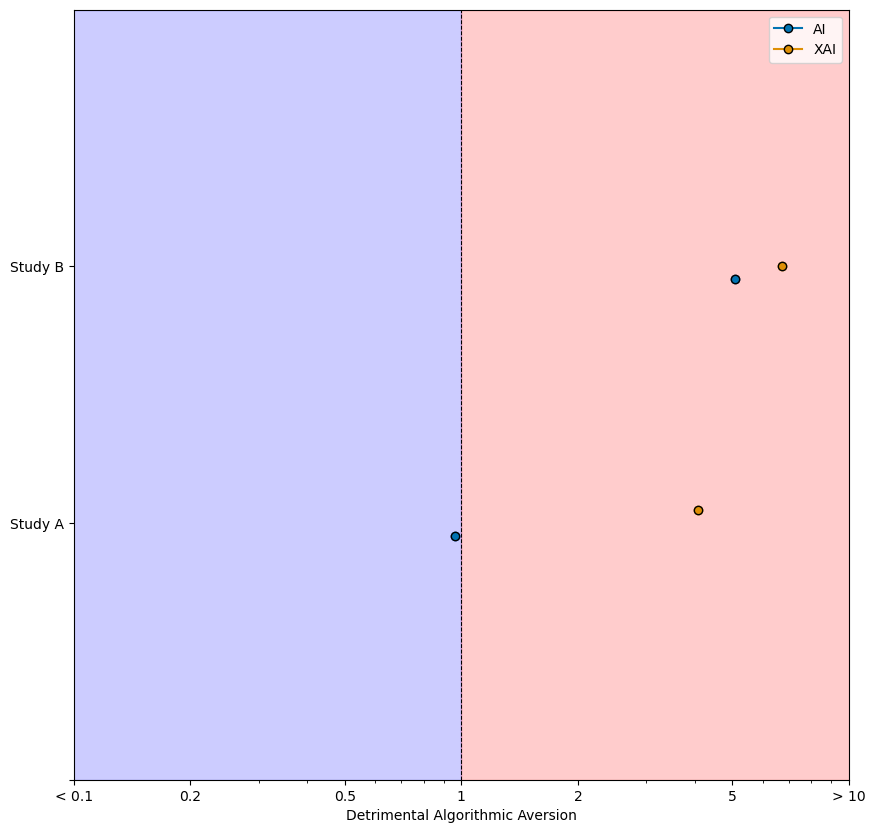

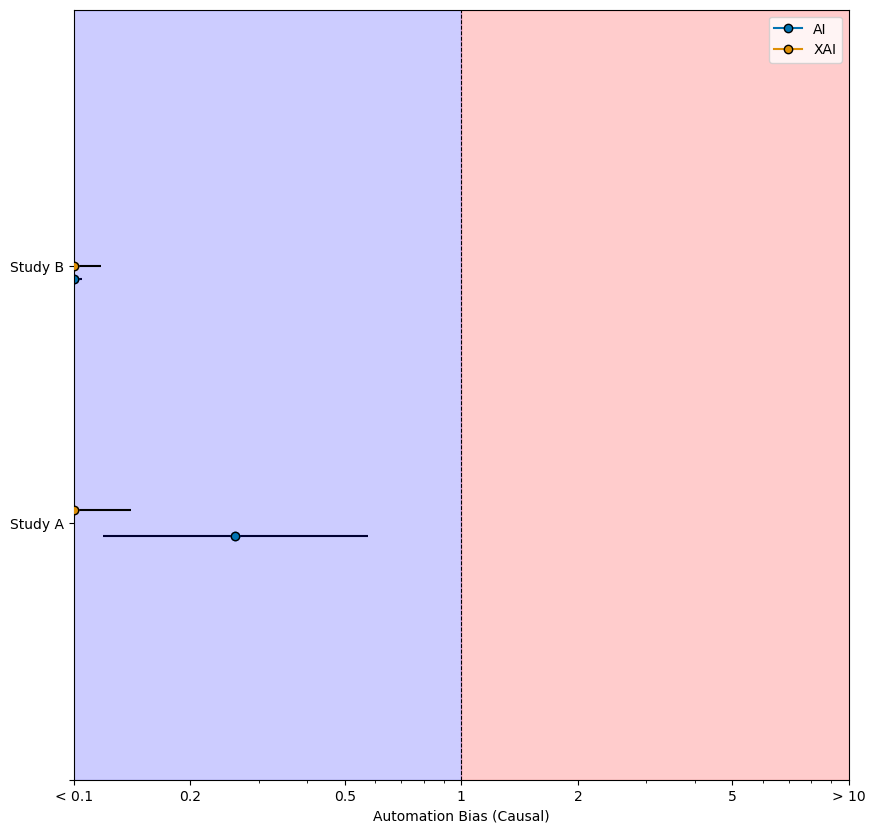

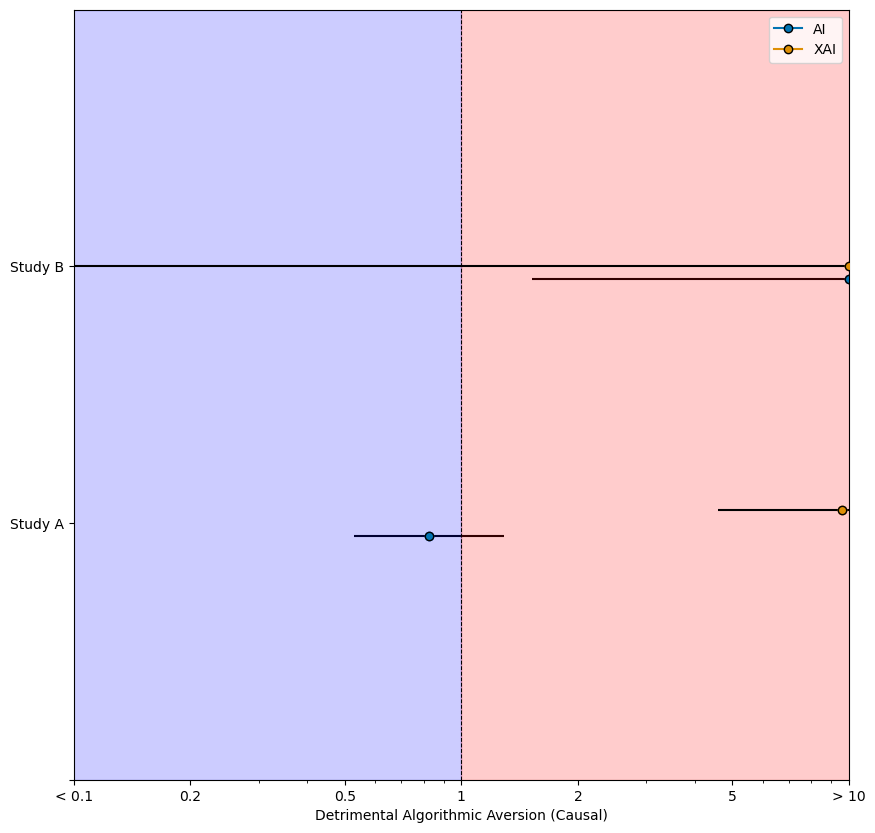

In [9]:
reliance, arr, nnd, rr, rrr, lower_gen, upper_gen, lower_ab, upper_ab, lower_av, upper_av, lower_ab_caus, upper_ab_caus, lower_av_caus, upper_av_caus = compute_chi_diagrams(filename, cut=True)